#### Сравнение моделей

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

seaborn   : 0.11.1
matplotlib: 3.3.3
scipy     : 1.5.2
arviz     : 0.11.1
pymc3     : 3.10.0
numpy     : 1.19.2
pandas    : 1.1.4



__Проверка прогнозируемого апостериорного распределения__ (posterior predictive checks) используется для того, чтобы оценить, насколько хорошо модели объясняют данные, передаваемые как входные в модель. 

Цель проверок прогнозируемого апостериорного распределения заключается не в том, чтобы объявить модель неправильной – это уже известно заранее. 
Выполняя проверки прогнозируемого апостериорного распределения, мы надеемся лучше узнать и понять ограничения, присущие модели, чтобы правильно их учитывать, или попытаться улучшить качество модели.


Проверка прогнозируемого апостериорного распределения – это способ оценки модели в контексте достижения конкретной цели, следовательно, если у нас имеется более одной модели, то можно воспользоваться проверками прогнозируемого апостериорного распределения для их сравнения.

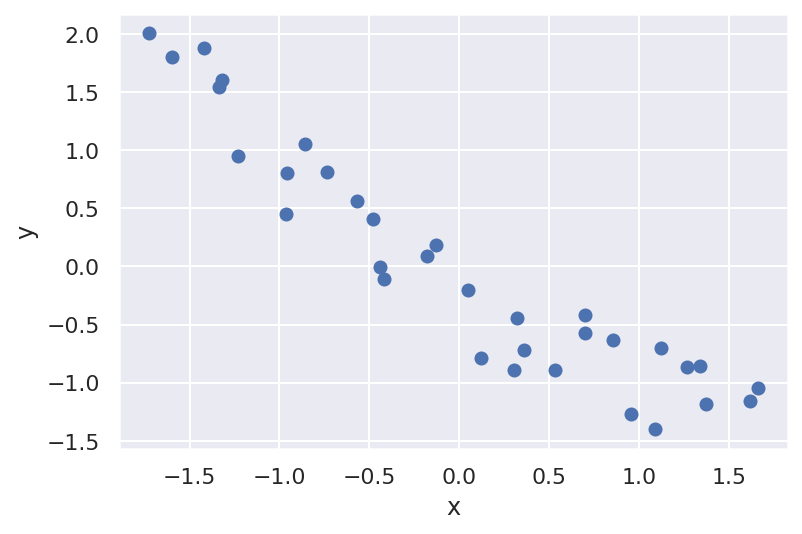

In [3]:
dummy_data = np.loadtxt('data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    eps = pm.HalfNormal('eps', 5)
    mu = alpha + beta*x_1s[0]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_1s)
    trace_l = pm.sample(2000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [5]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=order)
    eps = pm.HalfNormal('eps', 5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_1s)
    trace_p = pm.sample(2000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.715836858136972, but should be close to 0.8. Try to increase the number of tuning steps.


Сформируем диаграмму среднего значения для обеих моделей

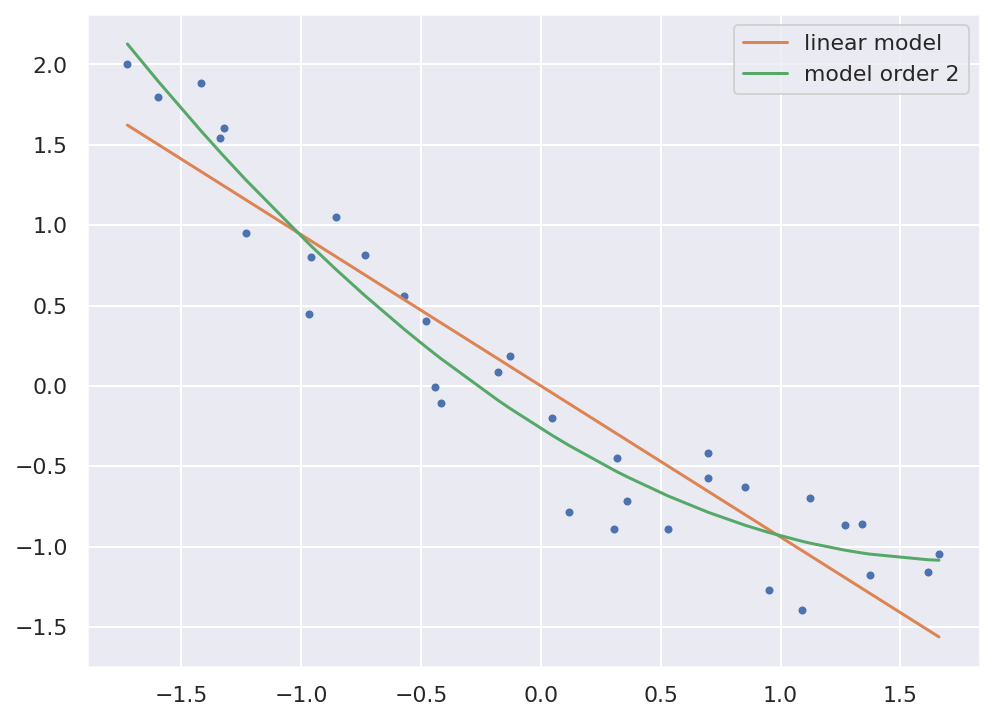

In [6]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['alpha'].mean()
β_l_post = trace_l['beta'].mean(axis=0)
y_l_post = α_l_post + β_l_post * x_new

fig = plt.figure(figsize=(8,6))
plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['alpha'].mean()
β_p_post = trace_p['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

α_p_post = trace_p['alpha'].mean()
β_p_post = trace_p['beta'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p)

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()
plt.show()

Получаем выборки прогнозируемого апостериорного распределения:

In [7]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


([], [])

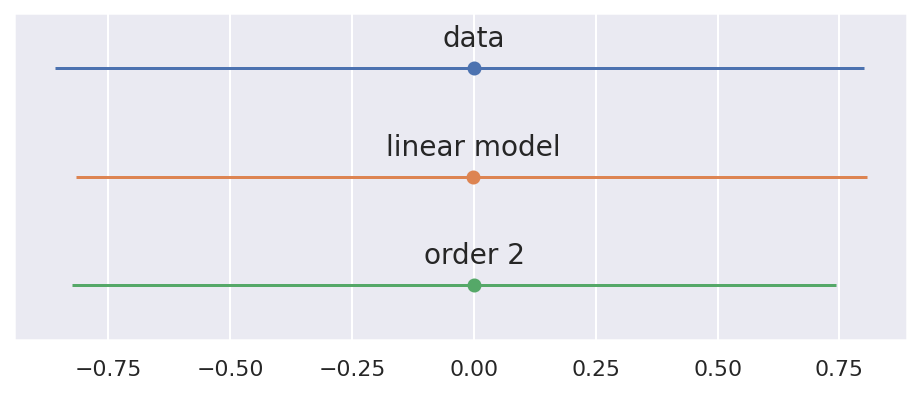

In [8]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

График отображает среднее значение и интерквартильный
размах (interquartile range – IQR) для данных, исследуемых с помощью линейной и квадратической модели. По этой диаграмме вычисляется среднее арифметическое выборок прогнозируемого апостериорного распределения для каждой модели. 

Здесь можно видеть, что среднее значение (как среднее арифметическое) успешно воспроизведено обеими моделями, а интерквартильный размах не очень широк. Тем не менее наблюдаются некоторые небольшие различия, которые в реальной задаче, вероятнее всего, потребуют более пристального внимания.

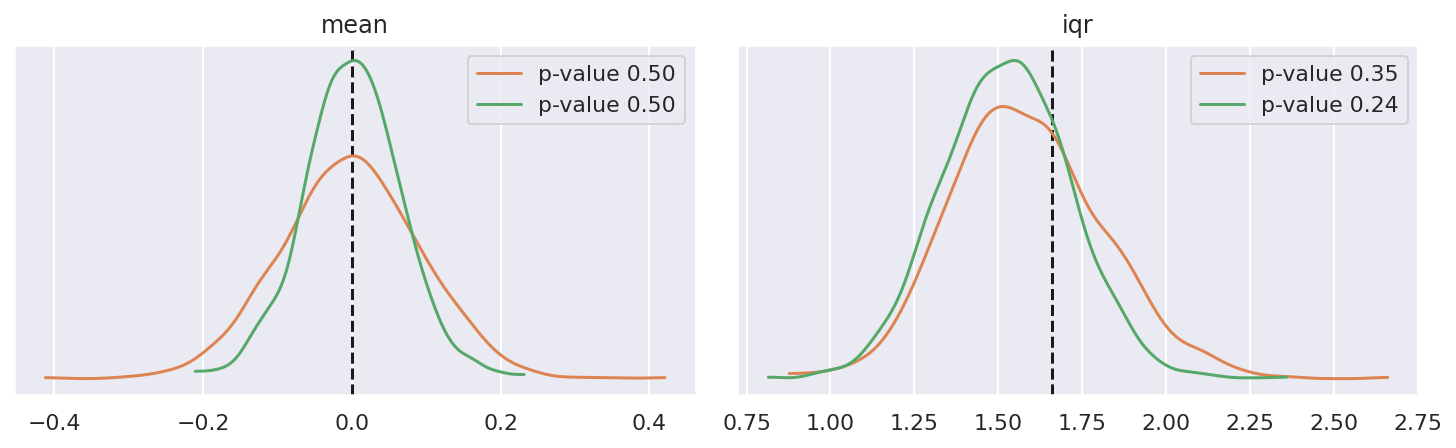

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}',
        ax=ax[idx])
        ax[idx].set_title(func.__name__)
        ax[idx].set_yticks([])
        ax[idx].legend()

Для обоих наборов данных вычислены обобщающие статистические характеристики (среднее значение и интерквартильный размах в рассматриваемом примере), затем было определено пропорциональное отношение количества случаев, когда обобщенные статистические характеристики больше или равны статистическим характеристикам, вычисленным по реальным данным. 

Если реальные и имитационные данные согласованы, то мы должны ожидать p-значение, близкое к 0.5, в противном случае наблюдается отклонение прогнозируемого апостериорного распределения.


    Байесовские p-значения – это всего лишь способ получения числовой меры соответствия проверкам прогнозируемого апостериорного распределения.


#### Лезвие Оккама

При выборе из нескольких вариантов рекомендуется использовать правило,
известное как лезвие Оккама (Occam), которое в свободном и кратком изложении выглядит так:

    При наличии двух и более равнозначных объяснений одного явления следует выбрать самое простое.

При сравнении моделей следует всегда принимать во внимание и другой
фактор – точность, то есть насколько точно модели соответствуют данным.

Ранее мы уже встречались с некоторыми мерами точности, такими как коэффициент детерминации, который можно интерпретировать как пропорцию
объясняемой дисперсии в линейной регрессии.

Кроме того, проверки прогнозируемого апостериорного распределения основаны на понятии точности данных. Если имеются две модели и одна из них лучше объясняет данные, чем другая, то мы должны выбрать первую модель, то есть нам нужна модель с более высокой точностью.

При сравнении моделей мы интуитивно стремимся к выбору моделей с высокой точностью, и которые являются более простыми. Проблема этого баланса на самом деле не так проста.

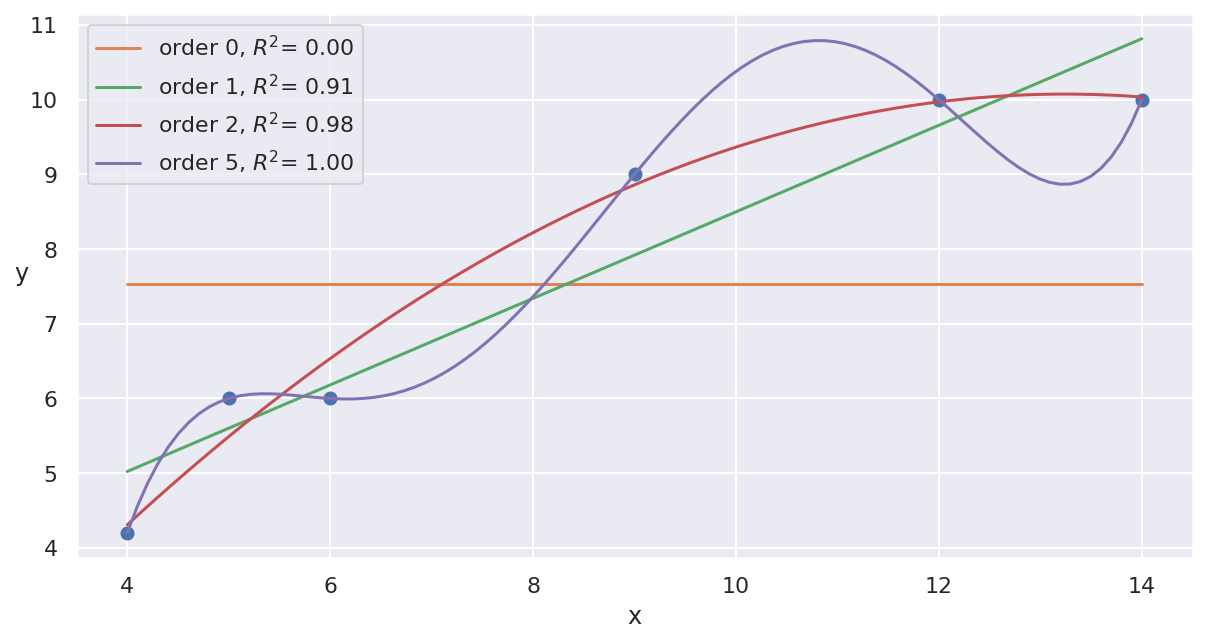

In [10]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

В идеальном случае нам хотелось бы получить модель
без переподгонки и недоподгонки. В реальности приходится идти на компромисс и каким-либо образом оптимизировать и настраивать используемые модели.

Компромисс обычно выражается в терминах, обозначающих понятия дисперсии (variance) и смещения (bias)

* большое смещение является результатом работы модели со слабой возможностью согласования данных

* высокий уровень дисперсии – результат работы модели с высокой чувствительностью к подробностям в данных

Как сравнивать не крайние случаи моделей, как в представленном примере:

1. Оценка на отложенной выборке
2. Кросс-валидация (K-fold, LOOCV)
3. Информационные критерии

#### Log-likelihood and deviance

Простейший способ оценки подгонки - MSE.

Более общий вариант - логарифм функции правдоподобия.

При нормальном значении правдоподобия оно становится пропорциональным среднеквадратической ошибке MSE.

На практике и по историческим причинам часто напрямую не используют логарифмическую функцию правдоподобия. Вместо нее применяется числовая характеристика, называемая отклонением (deviance):

$$deviance=-2\sum^{n}_{i=1}logp(y_i |\theta)$$

Отклонение используется как в байесовской, так и в небайесовской статистике. 

Различие состоит в том, что в байесовском анализе $\theta$ оценивается по апостериорному распределению, поэтому точно так же, как любая числовая характеристика, выводимая из апостериорного распределения, θ обладает собственным распределением. 

С другой стороны, в небайесовском анализе $\theta$ – это точечная оценка.


* чем меньше deviance, тем больше значение логарифмической функ правдоподобия и тем выше степень согласования прогнозов модели с данными. Следовательно, необходимо стремиться к малым значениям отклонения.

* deviance измеряет точность в пределах выборки модели, следовательно, сложные модели в общем случае будут давать меньшие значения отклонения, чем более простые модели. Таким образом, в сложные модели необходимо включать некоторый штраф.

Вместе с этим информационные критерии объединяет их схема конструирования - наличие определенным образом подсчитанного deviance и штрафного коэффициента или отдельного члена.

__Критерий AIC (Акаике):__
$$AIC=-2\sum^n_{i=1}logp(y_i|\hat{\theta}_{MLE}) + 2pAIC, $$
где MLE - оценка maximum likelihood, pAIC-количество параметров модели. 

(-2 - коэффициент, присутствующих до сих пор по историческим причинам)

В таком виде критерий помогает оценить модели с точечной подгонкой параметров.


__Критерий WAIC (Widely applicable information criterion):__

$$WAIC=-2lppd + 2pWAIC$$

$$WAIC=-2\sum_{i}^{n}log(\frac{1}{S}\sum_{s=1}^{S}p(y_i|\theta^{s})) + 2\sum_{i}^{n} [\sum_{s=1}^{S}(logp(y_i|\theta^{s}))]$$


lppd - log pointwise predictive density, логарифм поточечно определяемой прогнозируемой плотности.


Критерий применим для байесовских моделей.


__Парето-сглаженная выборка по значимости для перекрестной проверки LOOCV:__


Парето-сглаженная выборка по значимости для перекрестной проверки
LOOCV – это метод, используемый для аппроксимации результатов перекрестной проверки LOOCV, но без действительного выполнения K итераций.

Основная идея заключается в возможности аппроксимации
LOOCV при помощи соответствующего перерасчета весовых коэффициентов правдоподобий.

Проблема заключается в том, что результаты нестабильны. Для
устранения нестабильности был введен новый метод с применением подхода, названного парето-сглаженной выборкой по значимости для перекрестной проверки LOOCV (__Pareto-smoothed importance sampling – PSIS__), который может применяться для вычисления более надежных оценок LOOCV

__Байесовский информационный критерий (BIC):__


Название может ввести в заблуждение.
Байесовский информационный критерий был предложен как способ устранения некоторых проблем с информационным критерием Аикаке, и для этого автор воспользовался байесовским обоснованием. Но BIC в действительности не является байесовским методом, фактически он похож на AIC.

#### Сравнение моделей с PyMC3

In [11]:
waic_l = az.waic(trace_l)
waic_l

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.39     2.68
p_waic        2.48        -

In [12]:
waic_p = az.waic(trace_p)
waic_p

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic    -4.61     2.33
p_waic        2.68        -

In [13]:
loo_l = az.loo(trace_l)
loo_l

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 8000 by 33 log-likelihood matrix

         Estimate       SE
elpd_loo   -14.41     2.68
p_loo        2.50        -

In [14]:
loo_p = az.loo(trace_p)
loo_p

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 8000 by 33 log-likelihood matrix

         Estimate       SE
elpd_loo    -4.65     2.34
p_loo        2.72        -

Поскольку значения WAIC/LOO всегда интерпретируются как относительные, то есть эти значения сравниваются для нескольких различных моделей, библиотека ArviZ предоставляет две вспомогательные функции для удобства сравнения. Первая функция az.compare:

In [15]:
cmp_df = az.compare({'model_l':trace_l, 
                     'model_p':trace_p},
                    ic='loo',
                    method='BB-pseudo-BMA')
cmp_df

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.646507,2.718132,0.000000,0.997828,2.696241,0.000000,False,log
model_l,1,-14.414873,2.504486,9.768366,0.002172,2.244605,2.676872,False,log


<AxesSubplot:xlabel='Log'>

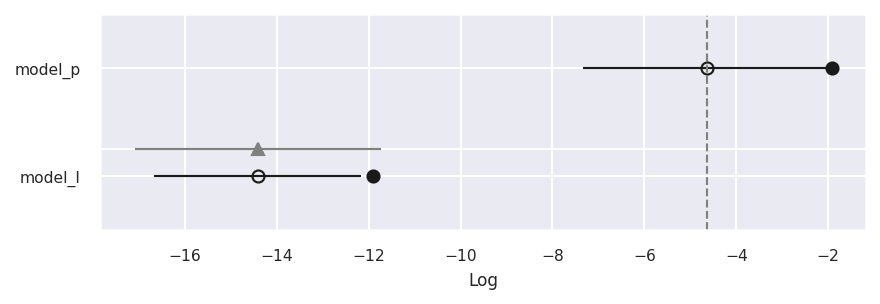

In [16]:
az.plot_compare(cmp_df)

In [17]:
cmp_df = az.compare({'model_l':trace_l, 
                     'model_p':trace_p},
                    ic='waic',
                    method='BB-pseudo-BMA')
cmp_df

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_p,0,-4.610932,2.682558,0.00000,0.998767,2.664245,0.000000,False,log
model_l,1,-14.394362,2.483976,9.78343,0.001233,2.350953,2.673467,False,log


<AxesSubplot:xlabel='Log'>

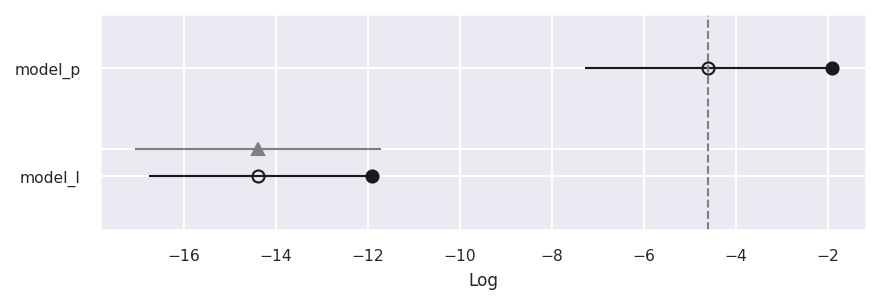

In [18]:
az.plot_compare(cmp_df)

* пустой (незакрашенный) кружок представляет значения WAIC, а черные полоски ошибок, связанные с ним, – это значения стандартного отклонения WAIC;


* наименьшее значение WAIC изображено вертикальной штриховой серой линией для упрощения сравнения с другими значениями WAIC;


* черные (закрашенные) кружки – отклонение в пределах выборки для каждой модели: для WAIC – значение 2pWAIC соответствующего значения WAIC;


* для всех моделей, за исключением модели с наивысшей оценкой, также показан значок треугольника, отображающий значение разности WAIC между рассматриваемой моделью и наилучшей моделью, а серая полоска ошибок, связанная с этим значком, – это стандартная ошибка разностей между WAIC с наивысшей оценкой и значением WAIC для каждой модели.

В такой интерпретации для рассматриваемого выше примера это очень
простой выбор – квадратичная модель самая лучшая. 

Отметим, что стандартные ошибки не перекрываются, что прибавляет уверенности в этом варианте выбора. Если бы стандартные ошибки перекрывались, то мы получили бы менее определенный ответ.

В более обобщенном смысле информационные критерии WAIC и LOO могут помочь только в том случае, когда выбор происходит из заданного набора сравниваемых моделей, но вряд ли эти критерии помогут определить, что какая-либо модель действительно является правильным решением конкретной задачи.

Поэтому критерии WAIC и LOO должны быть дополнены проверками
прогнозируемого апостериорного распределения, а также другой информацией и тестами, помогающими увидеть модели и данные с точки зрения области знаний, связанной с решаемой задачей.

#### Усреднение моделей

Еще один подход – полный охват неопределенности при сравнении моделей и выполнение усреднения моделей.

1) Один из вариантов вычисления весовых коэффициентов - применение WAIC:
$$w_i=\frac{e^{0.5dE_i}}{\sum^M_j e^{-0.5dE_j}},$$

где $dE_i$-разность между значениями WAIC i-й модели и модели с наименьшим WAIC.

Метод является в чистом виде эвристическим, можно использовать другие информационные критерии.

Такое усредение также называется "псевдоусреднение байесовского моделирования". Истинное усреднение байесовского моделирования - выполняется с предельными правдободобиями

Используя библиотеку PyMC3, можно вычислить весовые коэффициенты
по формуле выше, передавая аргумент `method='pseudo-BMA'` (псевдоусреднение байесовского моделирования) в функцию `az.compare.`

2) Стекинг прогнозируемых распределений разных моделей

Основная идея состоит в объединении нескольких моделей в метамодель посредством минимизации отклонения между метамоделью и реальной генерируемой моделью.

В библиотеке PyMC3 этот метод применяется при пере-
даче аргумента `method='stacking'` в функцию `az.compare`

3) Существуют и другие способы усреднения моделей, например явное созда ние метамодели, включающей все рассматриваемые при сравнении модели как субмодели. Такую модель можно создать тем же способом, которым выполняется вывод параметра каждой субмодели.

__Простейший пример получения взвешенного прогнозируемого апостериорного распределения выборки:__

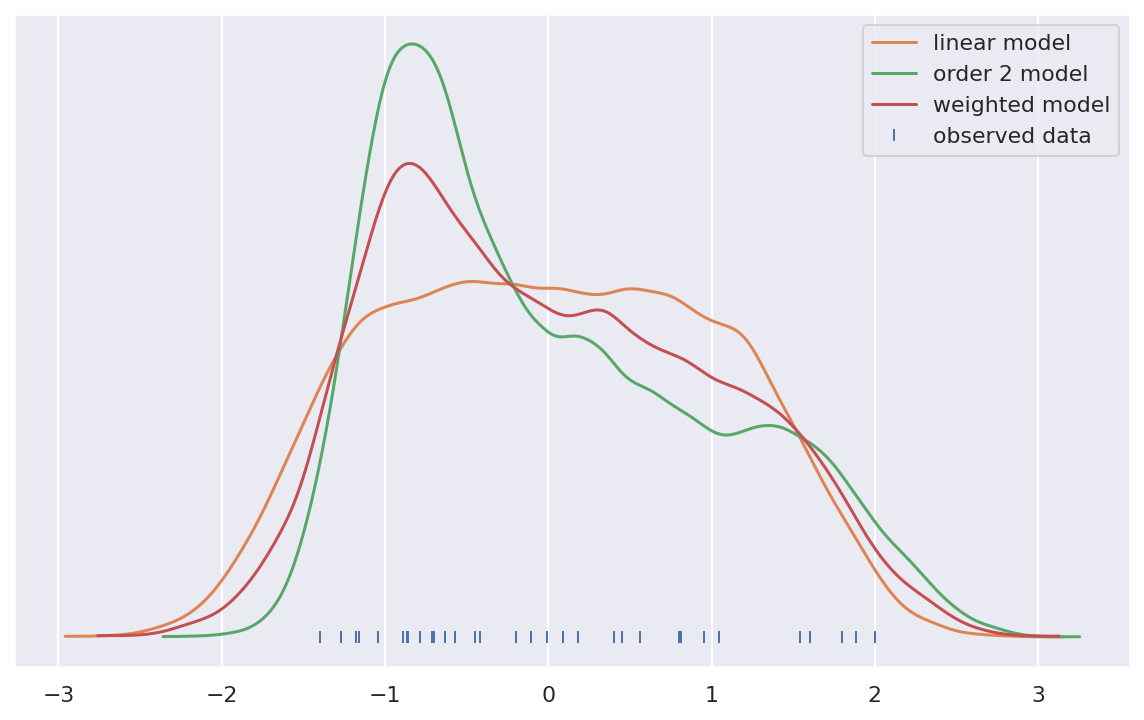

In [19]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w(
    [trace_l, trace_p],
    samples=1000,
    models=[model_l, model_p],
    weights=[w, 1-w]
)

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, 
            label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'},
            label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
            label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')

plt.yticks([])
plt.legend()
plt.show()

Модели также можно сравнивать между собой __коэффициентами Байеса__.

Используя теорему Байеса, можно сказать, что:

$$p(\theta|D)=\frac{p(D|\theta)p(\theta)}{p(D)},$$

где $D$-данные.

Сюда же можно добавить зависимость от самой модели $M$:

$$p(\theta|D, M_k)=\frac{p(y|\theta, M_k)p(\theta, M_k)}{p(D|M_k)},$$

Знаменатель - evidence, marginal likelihood. При статистическом выводе константу нормализации можно опускать, но с точки зрения сравнения моделей - это важная часть. Соответственно, если цель - выбор лучшей модели из $k$, то можно выбрать модель с наибольшим $p(D|M_k)$.

Поскольку для сравнения важны относительные значения, то с практической точки зрения лучше вычислять соотношение предельных правдоподобий - коэффициенты Байеса:


$$BF=\frac{p(D|M_0)}{p(D|M_1)}$$

Но если априорные вероятности не одинаковы для моделей:

$$\frac{p(M_0|D)}{p(M_1|D)}=\frac{p(D|M_0)}{p(D|M_1)} \frac{p(M_0)}{p(M_1)},$$

т.е. апостериорные шансы = коэф. Байеса  *  априорные шансы


Если $BF>1$, то модель $M_0$ объясняет данные лучше $M_1$.

* Подход уже внутри себя штрафует более "длинные" модели по параметрам.

* Предельное правдоподобие затратно для вычислений.

* Предельное правдоподобие сильно чувствительно к изменению априорного распределения.

In [20]:
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

In [21]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (4, 8)
    m_1 = (8, 4)
    
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    theta = pm.Beta('theta', m[0], m[1])
    y= pm.Bernoulli('y', theta, observed=y_d)
    trace_BF = pm.sample(5000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


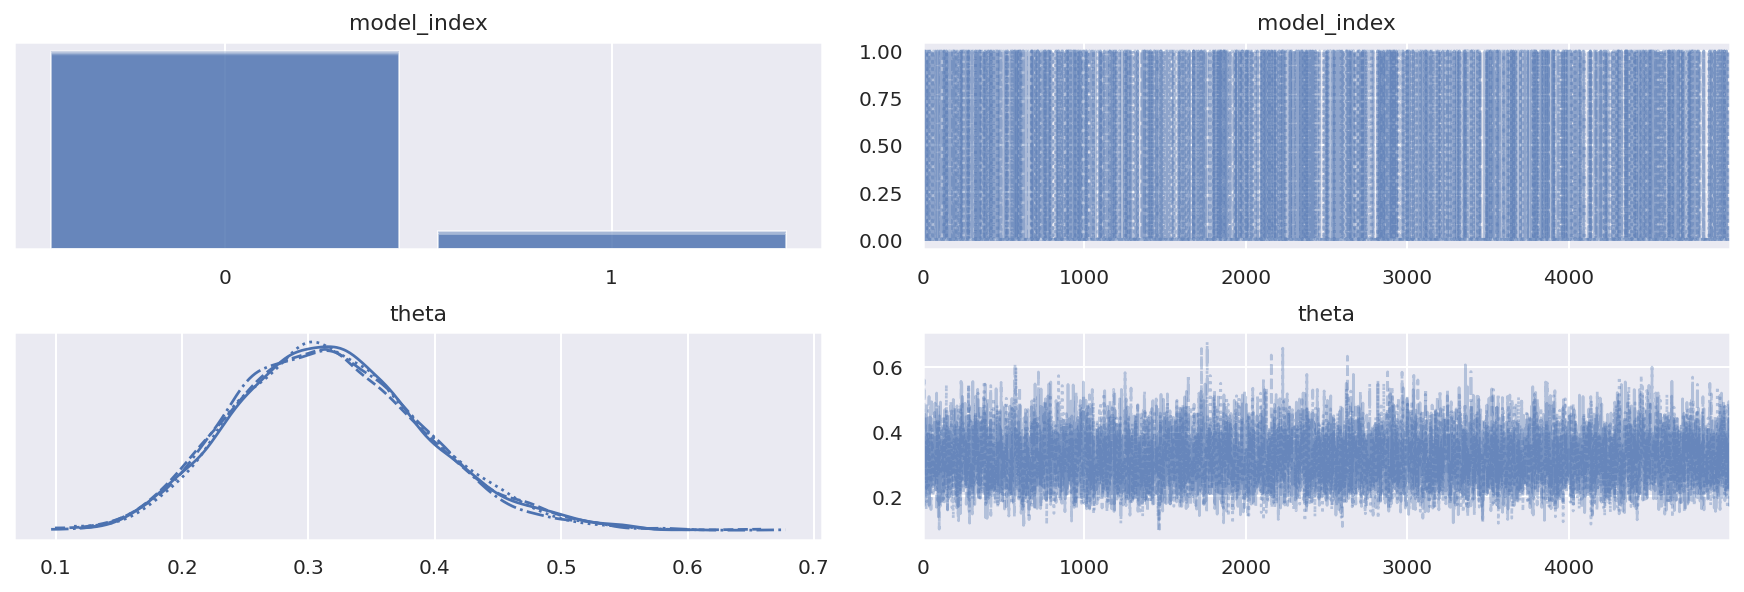

In [22]:
az.plot_trace(trace_BF)
plt.show()

In [23]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

11.57071024512885

В результате получаем значение ~ 11, означающее, что модель 0 предпочтительнее модели 1.

Для вычисления коэффициента Байеса можно применить последовательный метод Монте-Карло - SMC
* https://docs.pymc.io/notebooks/SMC2_gaussians.html
* https://docs.pymc.io/notebooks/Bayes_factor.html

In [24]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500)

with pm.Model() as model_BF_1:
    theta = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.205
Stage:   1 Beta: 0.674
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.210
Stage:   1 Beta: 0.680
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.204
Stage:   1 Beta: 0.674
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.210
Stage:   1 Beta: 0.686
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.202
Stage:   1 Beta: 0.668
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.214
Stage:   1 Beta: 0.684
Stage:   2 Beta: 1.000


In [25]:
trace_BF_0.report.log_marginal_likelihood

array([-18.96796588, -18.97170411, -18.97818574, -18.97338374,
       -18.9992433 , -18.95575699])

In [26]:
trace_BF_1.report.log_marginal_likelihood

array([-21.38996116, -21.40492984, -21.39246017, -21.3420835 ,
       -21.41254572, -21.36723607])

In [27]:
BF_smc = np.exp(trace_BF_0.report.log_marginal_likelihood - trace_BF_1.report.log_marginal_likelihood)
BF_smc

array([11.26832029, 11.39558193, 11.18165437, 10.68349208, 11.17079102,
       11.15044137])

In [28]:
np.mean(BF_smc)

11.14171350910627

Коэффициенты Байеса ориентированы на определение лучшей модели, в то время как информационные критерии $WAIC$ и $LOO$ направлены на то, чтобы узнать, какая модель дает более точные прогнозы.

#### Регуляризация априорных распределений

В небайесовской статистике идея регуляризации принимает форму двух модификаций метода наименьших квадратов:
    * Ridge (гребневая) регрессия
    * Lasso-регрессия
    
С байесовской точки зрения Ridge-регрессию можно интерпретировать как использование __нормальных распределений для бета-коэффициентов__ (линейной модели) с малым стандартным отклонением, которое принудительно смещает эти коэффициенты к нулю.


Сдругой стороны, Lasso-регрессию с байесовской точки зрения можно интерпретировать как оценку апостериорного максимума, вычисленную из модели с __априорными распределениями Лапласа для бета-коэффициентов__. Распределение Лапласа выглядит похожим на гауссово распределение, но его первая производная
не определена в нулевой точке (острый пик).
В распределении Лапласа основная масса вероятностей концентрируется намного ближе к нулю по сравнению с нормальным распределением. Идея использования такого распределения возникла потому, что оно обеспечивает и регуляризацию, и отбор переменных (признаков).


Существуют байесовские модели, которые могут использоваться и для создания разреженности, и для отбора переменных (признаков), например модель подковы (horseshoe) и финской подковы (Finnish horseshoe).

#### Entropy

The entropy function is:

$$H(p)=-\sum_{i}p_ilog(p_i)$$

Интуитивно понятно, что чем размазанней распределение, чем больше его размах, тем больше энтропия.

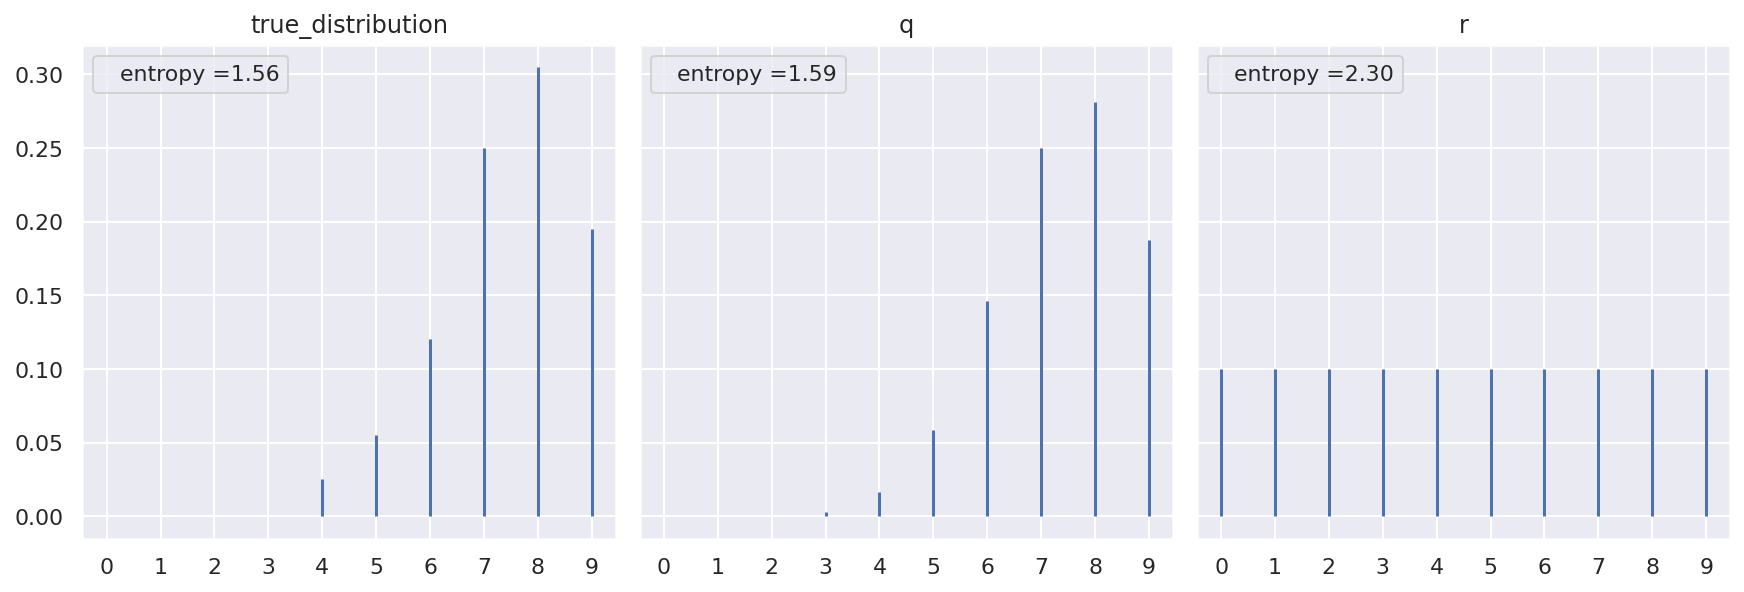

In [29]:
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)
true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
q_pmf = q.pmf(x)
r_pmf = r.pmf(x)

_, ax = plt.subplots(1, 3, figsize=(12, 4), 
                     sharey=True,
                     constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy ={stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

Энтропия также связана с концепцией информации или с противоположной концепцией неопределенности.

В действительности среди байесовских аналитиков существует
группа, которая использует энтропию для обоснования малоинформативных или регуляризируемых априорных распределений. Такой подход известен под названием __принципа максимальной энтропии__. Необходимо найти распределение с наибольшей возможной энтропией (то есть наименее информативное), но при этом также необходимо учитывать ограничения, предварительно определенные в условии решаемой задачи.


Примеры распределений с наибольшей энтропией при указанных конкретных ограничениях:

* без ограничений – равномерное распределение (непрерывное или дискретное, в соответствии с типом переменной);

* положительное среднее значение – экспоненциальное распределение;

* с заданной дисперсией – нормальное распределение;

* только две неупорядоченные выходные переменные и постоянное среднее значение – биномиальное распределение или распределение Пуассона (особый случай биномиального), если исследуются редкие события;

#### Kullback-Leibler divergence

Расстояние Кульбака-Лейблера измеряет близость двух распределений:

$$D_{KL}(p||q)=\sum_{i}p_ilog\frac{p_i}{q_i},$$

где $D_{KL}(p||q)-$ расстояние от $q$ до $p$. Порядок интерпретации в таком виде обратный, метрика как таковая не является расстоянием, поскольку для него не выполняется свойство расстояния - неравенство треугольника, т.е. при смене порядка в формуле, метрика изменится, оно не симметрично.

Также есть интерпретация $D_{KL}(p||q)$ как добавочной энтропии или uncertanty, которая появляется при аппроксимации $p$ с помощью распределения $q$:

$$D_{KL}(p||q)=\sum_i p_i log p_i - \sum_i p_i log q_i=\sum_i p_i(log p_i - log q_i)=\sum_{i}p_ilog\frac{p_i}{q_i}$$

In [40]:
e1 = stats.entropy(true_distribution, q_pmf)
e2 = stats.entropy(true_distribution, r_pmf)
print('e1: %.4f e2: %.4f' % (e1, e2) )

e1: 0.0097 e2: 0.7395


In [41]:
print(stats.entropy(r_pmf, q_pmf), stats.entropy(q_pmf, r_pmf))

2.756929658156367 0.7154903060638594


Таким образом $D_{KL}(p||q)$ показывает, насколько хорошо $q$ апроксимирует $p$. 

Иначе - как сильно мы будем удивлены, увидев $q$, ожидая при этом $p$.

$D_{KL}$ в целом можно применить для сравнения моделей:

$$D_{KL}(p||q)-D_{KL}(p||r)=$$


$$=(\sum_i p_i log p_i - \sum_i p_i log q_i) - (\sum_i p_i log p_i - \sum_i p_i log r_i)=$$


$$=\sum_i p_i (log r_i - log q_i)=\sum_i p_i log (\frac{r_i}{q_i})=-\sum_i p_i log (\frac{q_i}{r_i}),$$

что в некотором смысле наталкивает на информацинные критерии.